In [1]:
'''
사전 학습된 ConvNet을 이용한 전이 학습

작성자: 이선웅
작성일: 2021.07.09
'''

'\n사전 학습된 ConvNet을 이용한 전이 학습\n\n작성자: 이선웅\n작성일: 2021.07.09\n'

# 사전 학습된 ConvNet을 이용한 전이 학습

이 튜토리얼에서는 사전 훈련된 네트워크에서 전이 학습을 사용하여 고양이와 개의 이미지를 분류하는 방법을 배우게 됩니다.

사전 훈련된 모델은 이전에 대규모 데이터셋에서 훈련된 저장된 네트워크로, 일반적으로 대규모 이미지 분류 작업에서 훈련된 것입니다. 사전 훈련된 모델을 그대로 사용하거나 전이 학습을 사용하여 이 모델을 주어진 작업으로 사용자 정의하세요.

이미지 분류를 위한 전이 학습을 직관적인 시각에서 바라보면 모델이 충분히 크고 일반적인 데이터 집합에서 훈련된다면, 이 모델은 사실상 시각 세계의 일반적인 모델로서 기능할 것이라는 점입니다. 그런 다음 대규모 데이터셋에서 대규모 모델을 교육하여 처음부터 시작할 필요 없이 이러한 학습된 특징 맵을 활용할 수 있습니다.

이번 notebook에서는 사전 훈련된 모델을 사용자 정의하는 두 가지 방법을 시도 해보겠습니다.:

1. 특징 추출: 새 샘플에서 의미 있는 형상을 추출하기 위해 이전 네트워크에서 학습한 표현을 사용합니다. 사전 훈련된 모델 위에 처음부터 교육할 새 분류기를 추가하기만 하면 이전에 데이터셋으로 학습한 특징 맵의 용도를 재사용할 수 있습니다. \\
전체 모델을 재훈련시킬 필요는 없습니다. 기본 컨볼루션 네트워크에는 그림 분류에 일반적으로 유용한 기능이 이미 포함되어 있습니다. 그러나 사전 훈련된 모델의 최종 분류 부분은 기존의 분류 작업에 따라 다르며 이후에 모델이 훈련된 클래스 집합에 따라 다릅니다.

2. 미세 조정: 고정된 기본 모델의 일부 최상위 층을 고정 해제하고 새로 추가 된 분류기 층과 기본 모델의 마지막 층을 함께 훈련시킵니다. 이를 통해 기본 모델에서 고차원 특징 표현을 "미세 조정"하여 특정 작업에 보다 관련성이 있도록 할 수 있습니다.

일반적인 기계 학습 일련의 과정을 진행합니다.

1. 데이터 검사 및 이해
2. 입력 파이프 라인 빌드(이 경우 Keras ImageDataGenerator를 사용)
3. 모델 작성
    - 사전 훈련된 기본 모델(또한 사전 훈련된 가중치)에 적재
    - 분류 층을 맨 위에 쌓기
4. 모델 훈련
5. 모델 평가

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## 데이터 전처리

### 데이터 다운로드 
고양이와 개의 데이터셋을 가져오기 위해 Tensorflow 데이터셋 이용합니다.

tfds패키지는 미리 정의 된 데이터를 가져오는 가장 쉬운 방법입니다. 본인 만의 데이터가 있고 Tensorflow에서 이 패키지를 이용해 데이터를 가져오려는 경우 이미지 데이터 가져오기를 확인하세요.

In [2]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

tfds.load 메소드는 데이터를 다운로드 및 캐시하고 tf.data.Dataset 오브젝트를 리턴합니다. 이러한 객체는 데이터를 조작하고 모델에 파이프하는 강력하고 효율적인 방법을 제공합니다.

"cats_vs_dogs" 는 표준 splits 기능을 정의하지 않으므로 subsplit 기능을 사용하여 각각 80%, 10%, 10%(훈련, 검증, 테스트)의 데이터로 나눕니다.

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete6RJY5G/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


tf.data.Dataset 객체에는 (이미지, 레이블) 쌍으로 이루어져 있습니다. 이미지는 가변적인 shape, 3개 채널로 구성되며, 레이블은 스칼라로 구성됩니다.

In [4]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


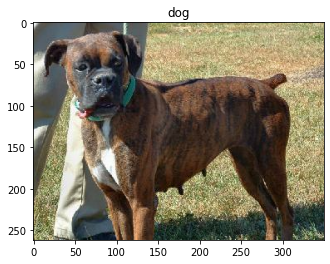

In [7]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(1):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

## 데이터 포맷
`tf.image` 모듈을 사용하여 이미지를 포맷하세요
이미지를 고정 된 입력 크기로 조정하고 입력 채널의 크기를 `[-1, 1]` 범위로 조정하세요.

In [8]:
IMG_SIZE = 160 # 모든 이미지는 160*160으로 크기 조정

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [12]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## 사전 훈련된 컨볼루션 네트워크로부터 기본 모델 생성하기
Google에서 개발한 MobileNet V2 모델로부터 기본 모델을 생성합니다. 이 모델은 1.4M 이미지와 1000개의 클래스로 구성된 대규모 데이터셋인 ImageNet 데이터셋를 사용해 사전 훈련된 모델입니다. ImageNet은 잭프루트 및 주사기와 같은 다양한 범주의 연구용 훈련 데이터셋입니다. 이 지식 기반은 특정 데이터셋에서 고양이와 개를 분류하는데 도움이 됩니다.

먼저 기능 추출에 사용할 MobileNet V2 층을 선택 해야 합니다. 가장 최근의 분류 층 ("맨 위층", 대부분의 머신 러닝 모델 다이어그램은 아래에서 위로 이동하므로)은 유용하지 않습니다. 대신에 flatten 연산을 하기 전에 맨 아래 층을 가지고 진행하겠습니다. 이 층을 "병목 층"이라고합니다. 병목 층은 맨 위층보다 일반성을 유지합니다.

먼저 ImageNet으로 훈련된 가중치가 저장된 MobileNet V2 모델을 인스턴스화 하세요. ** include_top = False ** 로 지정하면 맨 위에 분류 층이 포함되지 않은 네트워크를 로드하므로 특징 추출에 이상적입니다.

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

9412608/9406464 [==============================] - 0s 0us/step


이 특징 추출기는 각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환합니다. 이미지 배치 예제에서 수행하는 작업을 확인하세요:

In [17]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 특징 추출
이 단계에서는 이전 단계에서 작성된 컨벌루션 베이스 모델을 동결하고 특징 추출기로 사용합니다. 또한 그 위에 분류기를 추가하고 최상위 분류기를 훈렪시킵니다.

### 컨볼루션 베이스 모델 고정하기
모델을 컴파일하고 훈련시키기 전에 컨볼루션 베이스 모델을 고정 시키는 것이 중요합니다. 고정 (layer.trainable=False를 설정하여)하면 훈련 중 지정된 층의 가중치가 업데이트되지 않습니다. MobileNet V2에는 많은 층이 있으므로 전체 모델의 훈련 가능한 플래그를 False로 설정하면 모든 층이 고정됩니다.

In [18]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### 분류 층을 맨 위에 추가하기
특징 블록에서 예측을 하기위해 tf.keras.layers.GlobalAveragePooling2D 층을 사용하여 특징을 이미지 한개 당 1280개의 요소 벡터로 변환하여 5x5 공간 위치에 대한 평균을 구하세요.

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


tf.keras.layers.Dense층을 사용하여 특징을 이미지당 단일 예측으로 변환하세요. 이 예측은 logit또는 원시 예측 값으로 취급되므로 활성화 함수가 필요하지 않습니다. 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측합니다.

In [21]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
model = tf.keras.Sequential(
    [
     base_model,
     global_average_layer,
     prediction_layer
    ]
)

## 모델 컴파일
학습하기 전에 모델을 컴파일해야 합니다. 두 개의 클래스가 있으므로 모델이 선형 출력을 제공하므로 `from_logits = True`와 함께 이진 교차 엔트로피 손실을 사용하세요

In [23]:
base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


MobileNet의 2.5M 개의 매개 변수는 고정되어 있지만 Dense 층에는 1.2K 개의 trainable 매개 변수가 있습니다. 이것들은 두 개의 tf.Variable 객체, 즉 가중치와 바이어스로 나뉩니다.

In [24]:
len(model.trainable_variables)

2

## 모델 훈련
10 epochs 만큼 훈련 후, ~96%의 정확도를 볼 수 있습니다.

In [25]:
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(
    validation_batches, steps=validation_steps
)

20/20 [==============================] - 3s 53ms/step - loss: 0.7954 - accuracy: 0.4781


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.48


In [27]:
history = model.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches
)

Epoch 1/10
582/582 [==============================] - 49s 78ms/step - loss: 0.2165 - accuracy: 0.9009 - val_loss: 0.0877 - val_accuracy: 0.9712
Epoch 2/10
582/582 [==============================] - 47s 78ms/step - loss: 0.0706 - accuracy: 0.9751 - val_loss: 0.0632 - val_accuracy: 0.9811
Epoch 3/10
582/582 [==============================] - 47s 78ms/step - loss: 0.0567 - accuracy: 0.9803 - val_loss: 0.0558 - val_accuracy: 0.9815
Epoch 4/10
582/582 [==============================] - 47s 78ms/step - loss: 0.0508 - accuracy: 0.9821 - val_loss: 0.0520 - val_accuracy: 0.9815
Epoch 5/10
582/582 [==============================] - 46s 77ms/step - loss: 0.0475 - accuracy: 0.9829 - val_loss: 0.0497 - val_accuracy: 0.9824
Epoch 6/10
582/582 [==============================] - 47s 78ms/step - loss: 0.0454 - accuracy: 0.9833 - val_loss: 0.0483 - val_accuracy: 0.9824
Epoch 7/10
582/582 [==============================] - 47s 78ms/step - loss: 0.0437 - accuracy: 0.9838 - val_loss: 0.0473 - val_accuracy:

## 학습 곡선
MobileNet V2 기본 모델을 고정된 특징 추출기로 사용했을 때의 학습 및 검증 정확도 / 손실의 학습곡선을 살펴보자.

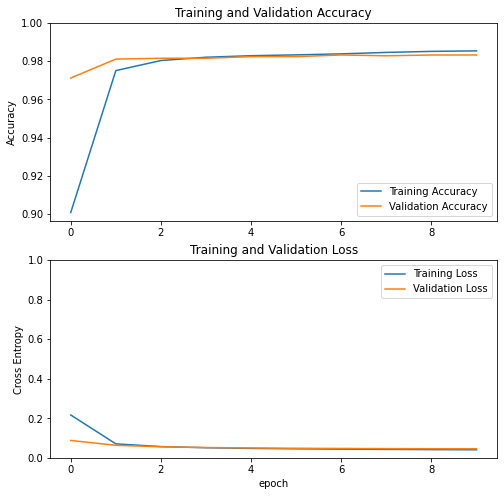

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

> Note: 유효성 검사 지표가 훈련 지표보다 명확하게 더 나은 이유는 tf.keras.layers.BatchNormalization 및 tf.keras.layers.Dropout과 같은 층이 훈련 중 정확도에 영향을 주기 때문입니다. 이것들은 유효성 검사 손실을 계산할 때 해제됩니다.

훈련 지표가 한 에포크 동안의 평균을 평가하는 반면, 유효성 검사 지표는 에포크 이후에 평가하므로 유효성 검사 지표는 약간 더 많이 훈련 된 모델을 볼 수 있기 때문입니다.

## 미세조정
기능 추출 실험에서는 MobileNet V2 기본 모델을 기반으로 몇 개의 층 만 학습했습니다. 사전 훈련된 네트워크의 가중치는 훈련 중에 업데이트 되지 **않았습니다**.

성능을 더욱 향상시키는 한 가지 방법은 추가 한 분류기의 훈련과 함께 사전 훈련된 모델의 최상위 레이어 가중치를 훈련(또는 "미세 조정")하는 것입니다. 훈련을 통해 가중치는 일반적인 특징 맵에서 개별 데이터셋과 관련된 특징으로 조정됩니다.

> Note: 사전 훈련된 모델을 훈련 불가능으로 설정하여 최상위 분류기를 훈련한 후에만 ​​시도해야 합니다. 사전 훈련된 모델 위에 무작위로 초기화된 분류기를 추가하고 모든 레이어를 공동으로 훈련하려고하면 (분류기가 가중치를 임의 설정하기 때문에) 그래디언트 업데이트의 크기가 너무 커지고 사전 훈련된 모델은 배운 것을 잊어버리게 됩니다.

또한 전체 MobileNet 모델이 아닌 소수의 최상위 층을 미세 조정해야 합니다. 대부분의 컨볼루션 네트워크에서 층이 높을수록 층이 더 전문화됩니다. 처음 몇 층은 거의 모든 유형의 이미지로 일반화되는 매우 간단하고 일반적인 특징을 학습합니다. 더 높은 수준으로 올라가면 훈련에 사용된 데이터 세트에 맞춰 특징이 점점 더 구체화 됩니다. 미세 조정의 목표는 이러한 전문화된 특징이 일반적인 학습을 덮어쓰지 않고 새 데이터셋에 맞춰 잘 동작 수 있도록 조정하는 것입니다.

### 최상위 층 고정 해제하기
base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정하면 됩니다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 합니다.

In [29]:
base_model.trainable = True

print(f'Number of layers in the base model: {len(base_model.layers)}')

# 해당 층 이후부터 미세 조정
fine_tune_at = 100

# fine_tune_at 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 154


### 모델 컴파일
훨씬 더 낮은 학습 비율로 모델 컴파일을 한다.

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
len(model.trainable_variables)

56

### 모델 훈련 계속하기
이미 수렴 상태로 훈련된 경우에, 이 단계는 정확도를 몇 퍼센트 포인트 향상시킵니다.

In [33]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_batches,
    epochs=total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data=validation_batches
)

Epoch 10/20
582/582 [==============================] - 56s 85ms/step - loss: 0.1259 - accuracy: 0.9521 - val_loss: 0.0786 - val_accuracy: 0.9789
Epoch 11/20
582/582 [==============================] - 50s 83ms/step - loss: 0.0664 - accuracy: 0.9738 - val_loss: 0.0522 - val_accuracy: 0.9828
Epoch 12/20
582/582 [==============================] - 50s 84ms/step - loss: 0.0479 - accuracy: 0.9823 - val_loss: 0.0504 - val_accuracy: 0.9815
Epoch 13/20
582/582 [==============================] - 50s 83ms/step - loss: 0.0400 - accuracy: 0.9846 - val_loss: 0.0531 - val_accuracy: 0.9794
Epoch 14/20
582/582 [==============================] - 50s 83ms/step - loss: 0.0331 - accuracy: 0.9868 - val_loss: 0.0544 - val_accuracy: 0.9798
Epoch 15/20
582/582 [==============================] - 50s 83ms/step - loss: 0.0256 - accuracy: 0.9907 - val_loss: 0.0530 - val_accuracy: 0.9828
Epoch 16/20
582/582 [==============================] - 49s 82ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.0544 - val_ac

MobileNet V2 기본 모델의 마지막 몇 층을 미세 조정하고 그 위의 분류기를 훈련할 때의 학습 및 검증 정확도 / 손실의 학습 곡선을 살펴 보겠습니다. 검증 손실은 훈련 손실보다 훨씬 높으므로 약간의 과적합이 나올 수 있습니다.

새로운 훈련용 데이터셋이 상대적으로 작고 원래 MobileNet V2의 데이터셋과 유사하기 때문에 약간의 과적합이 발생할 수 있습니다.

미세 조정 후 모델은 거의 98% 정확도에 도달합니다.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

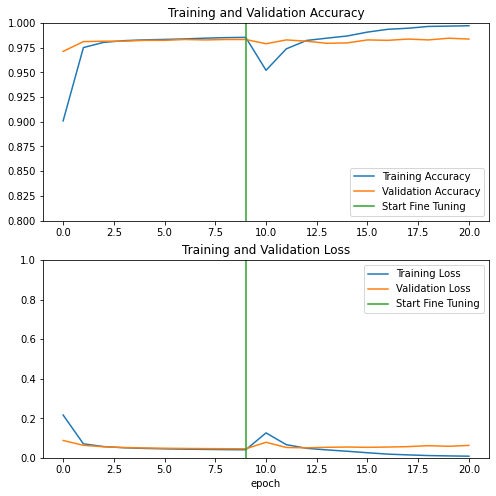

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 요약:
- 특징 추출을 위해 사전 훈련된 모델 사용하기: 작은 데이터셋으로 작업 할 때는 동일한 범주의 클래스의 더 큰 데이터셋으로 훈련시킨 사전 학습된 모델의 특징을 활용하는 것이 일반적입니다. 사전 훈련된 모델을 인스턴스화하고 완전히 연결된 분류기를 맨 위에 추가하면 됩니다. 사전 훈련된 모델은 "고정"되고 분류기의 가중치만 훈련 중에 업데이트됩니다. 이 경우 컨벌루션 베이스 모델은 각 이미지와 관련된 모든 특징을 추출하며 주어진 추출된 특징을 가지고 이미지 클래스를 결정하는 분류기를 훈련합니다.

- 사전 훈련된 모델을 미세 조정하기: 성능을 더욱 향상시키기 위해 사전 훈련된 모델의 최상위 계층을 미세 조정을 통해 새 데이터셋으로써 재사용 할 수 있습니다. 이 경우 모델이 주어진 데이터셋에 맞는 상위 레벨의 특징을 학습 할 수 있도록 가중치를 조정합니다. 이 기술은 일반적으로 훈련 데이터셋의 규모가 크고, 사전 훈련된 모델이 사용했던 원래 데이터셋과 매우 유사한 경우에 권장됩니다.

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.